In [1]:
import deepchem as dc
import torch
from deepchem.models import GCNModel
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import os
warnings.filterwarnings("ignore")
import torch.nn as nn

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clean_data = pd.read_csv(r"FinalClearData-refined.csv")

In [3]:
data = clean_data

In [4]:
smiles = data.SMILES.to_list()
labels = data.LABELS.to_list()
        
featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
X = featurizer.featurize(smiles)
        
dataset = dc.data.NumpyDataset(X=X, y=labels)
        
torch_data = dataset.make_pytorch_dataset()

In [5]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [6]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "FinalClearData-refined.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data

    
    

In [7]:
dataset = BBBDataset(root=".",)

Processing...
3011it [00:02, 1464.88it/s]
Done!


In [8]:
### Splitting of data
from torch.utils.data import random_split

train_set, test_set = random_split(dataset,[2000,1011]) ## 70:30

trainloader = DataLoader(train_set,shuffle=True,batch_size=256,drop_last=True) ## TrainLoader
testloader = DataLoader(test_set, shuffle=True,batch_size=256,drop_last=True)  ## TestLoader

## Applying PyGAT

In [9]:
### Monitor Real Time learning curve
from lrcurve import PlotLearningCurve

In [10]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [11]:
from dgl.nn import WeightAndSum
import torch.nn as nn
from torch_geometric.nn import GlobalAttention,GATConv
from torch_geometric.nn import global_add_pool,global_max_pool
from torch.nn import Sequential
import torch.nn.functional as F
from collections import Counter

In [12]:
class WeightedSumMax(nn.Module):
    """ Pooling layer"""
    
    def __init__(self,n_feats):
        super().__init__()
        
        self.n_feats = n_feats
        self.atom_weights = nn.Sequential(nn.Linear(n_feats, 1),
                                          nn.Sigmoid())
        
    def forward(self,x,batch):
        expanded_index = batch.unsqueeze(-1).expand(x.size())
        weights = self.atom_weights(x)
        weighted_feats = x*weights

        
        ## Loop to calculated weighted Sum
        prev_ind = 0
        expanded_data = []
        for i in Counter(pd.DataFrame(expanded_index)[0]).values(): ## features is 30 that's why last index is taken
            j = prev_ind + i
            extracted = torch.tensor(weighted_feats[prev_ind:j,:]) ## x replaced with weighted_feats
            summed = torch.sum(extracted,axis=0,keepdim=True) ## features of each nodes summed up
            maxed,index = torch.max(extracted,dim=0,keepdim=True) ## selecting the max 
            weighted= torch.cat([summed,maxed],dim=1) ## concating both
            expanded_data.append(weighted)
            prev_ind = prev_ind + i  
        
            _feats = torch.vstack(expanded_data)
        return _feats
        

In [13]:
class GATLayer(nn.Module):
    def __init__(self,in_feats,out_feats,n_heads=1,concat=True):
        super().__init__()
        
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.heads = n_heads
        
        ### Graph Layer
        self.GAT_conv = GATConv(in_channels=self.in_feats,out_channels=self.out_feats,
                                heads= self.heads,concat=concat,)
        
    
        ## Initiating Residual connection
        if concat:
            self.res_connection = nn.Linear(self.in_feats,self.out_feats*self.heads)
        else:
            self.res_connection = nn.Linear(self.in_feats,self.out_feats)

        
        
    def forward(self,x,edge_index):
        
        new_feats = self.GAT_conv(x,edge_index)
        res_feats = F.relu(self.res_connection(x))
        new_feats = new_feats + res_feats
        #new_feats = F.dropout(input=new_feats,p=0.5,training=self.training) ## Dropout in each layer
        
        return new_feats
    
    

In [21]:
from torch_geometric.nn import global_mean_pool,global_max_pool
from collections import Counter

class PyGAT(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        """
        GAT layer with 3 attention head for each node.
        """
        
        ## Graph attention layer
        self.GAT_Conv1 = GATLayer(in_feats= 30,out_feats= 8,n_heads= 8,concat=False)
        self.GAT_Conv2 = GATLayer(in_feats= 8, out_feats= 64,n_heads = 1,concat=False)
   
        
#         ## Pooling Layer
#         self.weighted = WeightedSumMax(16) ## weighted SumAndMax
        
        
        ## Predictor Layer
        self.predict = nn.Sequential(
                        nn.Linear(64, 128),
                        nn.ReLU(),
                        #nn.Dropout(p=0.5,),
                        #nn.BatchNorm1d(128), remvoing bach norm
                        nn.Linear(128, 1)
                                        )
        
    
                 
    def forward(self,data):
        
        ### Extracting data from batch
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        ### Stacking Layer
        x = self.GAT_Conv1(x=x,edge_index=edge_index)
        x = F.elu(x,alpha=0.2)
        x = self.GAT_Conv2(x=x,edge_index=edge_index)
        x = F.elu(x,alpha=0.2)
#         x = self.GAT_Conv3(x=x,edge_index=edge_index)
#         x = F.elu(x,alpha=0.2)
        
        x = global_max_pool(x,batch) ## Changed
#         x = self.weighted(x,batch) ## weighted sum
#         x = self.GlobalAtt(x,batch)
    
            
        ##Final predictor layer
        x = F.sigmoid(self.predict(x))
        
        return x

In [22]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = PyGAT()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,)

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"
net.to(device)

PyGAT(
  (GAT_Conv1): GATLayer(
    (GAT_conv): GATConv(30, 8, heads=8)
    (res_connection): Linear(in_features=30, out_features=8, bias=True)
  )
  (GAT_Conv2): GATLayer(
    (GAT_conv): GATConv(8, 64, heads=1)
    (res_connection): Linear(in_features=8, out_features=64, bias=True)
  )
  (predict): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

#### Metrics

In [23]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,matthews_corrcoef

In [24]:
## Base Metircs to convert probablity to binary
def base_metrics(y_prob,y_true):
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    
    return (np.array(y_true),y_prob)

In [25]:
## accuracy counter
def accuracy_counter(y_true,y_prob):
    return accuracy_score(y_true,y_prob)    

In [26]:
### F1_scorer
def f1_scorer(y_true,y_prob):
    return f1_score(y_true,y_prob)

In [27]:
### Precision
def precision_counter(y_true,y_prob):
    return precision_score(y_true,y_prob)

In [28]:
### Recall score
def recall_counter(y_true,y_prob):
    return recall_score(y_true,y_prob)
    

In [29]:
### ROC
def roc_auc_scorer(y_true,y_prob):
    return roc_auc_score(y_true,y_prob)

In [30]:
### MCC score
def MCC_scorer(y_true,y_prob):
    return matthews_corrcoef(y_true,y_prob)

#### Implementing Early stopping

In [31]:
from TorchTools import EarlyStopping
## initialize the early_stopping object
early_stopping = EarlyStopping(patience=20, verbose=True,path="GATcheckpoint.pt")

In [32]:
def train():
    
    net.train() ### training mode
    
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    ## metrics
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    Recall_score = recall_counter(true,proab)
    Precsion_score = precision_counter(true,proab)
    mcc_score = MCC_scorer(true,proab)
    
    return (av_loss,accuracy,f1_Score,roc_Score,Recall_score,Precsion_score,mcc_score)
        

In [33]:
@torch.no_grad()
def test(loader):
    
    net.eval() #### evaluation mode
    
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    
    ## metrics
    #accuracy = accuracy_counter(proab,y_true)
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    Recall_score = recall_counter(true,proab)
    Precsion_score = precision_counter(true,proab)
    mcc_score = MCC_scorer(true,proab)
    
    
    return (val,accuracy,f1_Score,roc_Score,Recall_score,Precsion_score,mcc_score)

In [34]:
from lrcurve import PlotLearningCurve
import numpy as np
epochs = 200

############# RealTime Plotting ###################

# plot = PlotLearningCurve(
#     mappings = {
#         'loss': { 'line': 'train', 'facet': 'loss' },
#         'val_loss': { 'line': 'validation', 'facet': 'loss' },
#         'acc': { 'line': 'train', 'facet': 'acc' },
#         'val_acc': { 'line': 'validation', 'facet': 'acc' },
#         'F1_train':{'line':"train","facet":"F1"},
#         'F1_val':{'line':"validation","facet":"F1"},
#     },
#     facet_config = {
#         'loss': { 'name': 'Binary Cross-Entropy', 'limit': [0, None], 'scale': 'linear' },
#         'acc': { 'name': 'Accuracy', 'limit': [0, 1], 'scale': 'linear' },
#         'F1': { 'name': 'F1 score', 'limit': [0, 1], 'scale': 'linear' }
#     },
#     xaxis_config = { 'name': 'Epoch', 'limit': [0, 500] }
# )



#############___________Metrics_________________
## Accuracy
traine_accuracy = []
vale_accuracy = []

### F1 score
train_f1 = []
test_f1 = []

### ROC score
train_roc = []
test_roc =  []

## Loss
epoch_loss = []
valida_loss = []

## Precision
train_pre = []
test_pre = []

## Recall
train_re = []
test_re = []

### MCC score
train_mcc = []
test_mcc =  []



#######_________________________ Training_loop__________________



for epoch in range(1,epochs):

    train_loss1,train_accuracy1,train_f1_score,train_roc_score,re_score_train,pre_score_train,mcc_score_train = train()

    train_loss2,train_accuracy2,train_f1_score2,train_roc2,re_score_train2,pre_score_train2,mcc_score_train2 = test(trainloader)

    val_loss,val_accuracy,val_f1,val_roc,re_score_val,pre_score_val,mcc_score_Val = test(testloader)


    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    #test_loss_full.append(test_loss)

    ### f1_score
    train_f1.append(train_f1_score)
    test_f1.append(val_f1)

    #### ROC Score
    train_roc.append(train_roc_score)
    test_roc.append(val_roc)

    ## accuracy
    traine_accuracy.append(train_accuracy1)
    vale_accuracy.append(val_accuracy)

    ## Precisison
    train_pre.append(pre_score_train)
    test_pre.append(pre_score_val)

    ## Recall
    train_re.append(re_score_train)
    test_re.append(re_score_val)
    
    #### MCC Score
    train_mcc.append(mcc_score_train)
    test_roc.append(mcc_score_Val)
    
    print(f"""Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1:.4f},
                                  val loss: {val_loss:.4f}, val accuracy: {val_accuracy:.4f},
                                  train F1: {train_f1_score}, val F1: {val_f1},
                                  train recall: {re_score_train}, val recall: {re_score_val},
                                  train precision: {pre_score_train}, test precision:{pre_score_val},
                                  train ROC: {train_roc_score}, val ROC: {val_roc},
                                  train MCC: {mcc_score_train}, val MCC: {mcc_score_Val},""")
    print()
    print()
        


Epoch: 001, Train loss: 0.6799, Train accuracy: 0.5977,
                                  val loss: 0.6698, val accuracy: 0.6094,
                                  train F1: 0.7481662591687042, val F1: 0.7572815533980582,
                                  train recall: 1.0, val recall: 1.0,
                                  train precision: 0.59765625, test precision:0.609375,
                                  train ROC: 0.5, val ROC: 0.5,
                                  train MCC: 0.0, val MCC: 0.0,


Epoch: 002, Train loss: 0.6724, Train accuracy: 0.6027,
                                  val loss: 0.6603, val accuracy: 0.6276,
                                  train F1: 0.7520891364902507, val F1: 0.7712,
                                  train recall: 1.0, val recall: 1.0,
                                  train precision: 0.6026785714285714, test precision:0.6276041666666666,
                                  train ROC: 0.5, val ROC: 0.5,
                                  train 

Epoch: 017, Train loss: 0.6102, Train accuracy: 0.6624,
                                  val loss: 0.6210, val accuracy: 0.6302,
                                  train F1: 0.7335975341259358, val F1: 0.7237354085603114,
                                  train recall: 0.7720111214087118, val recall: 0.808695652173913,
                                  train precision: 0.6988255033557047, test precision:0.6549295774647887,
                                  train ROC: 0.6342524050241315, val ROC: 0.5861660079051383,
                                  train MCC: 0.2784798680616203, val MCC: 0.1924558321843172,


Epoch: 018, Train loss: 0.5992, Train accuracy: 0.6669,
                                  val loss: 0.6131, val accuracy: 0.6536,
                                  train F1: 0.7527950310559006, val F1: 0.7285714285714285,
                                  train recall: 0.8432282003710575, val recall: 0.7547568710359408,
                                  train precision: 0.67988032

Epoch: 031, Train loss: 0.5230, Train accuracy: 0.7333,
                                  val loss: 0.5460, val accuracy: 0.7214,
                                  train F1: 0.791083916083916, val F1: 0.7708779443254817,
                                  train recall: 0.8434296365330848, val recall: 0.7929515418502202,
                                  train precision: 0.7448559670781894, test precision:0.75,
                                  train ROC: 0.7061376277241224, val ROC: 0.7053929683773393,
                                  train MCC: 0.4324894621290565, val MCC: 0.417149238399722,


Epoch: 032, Train loss: 0.5255, Train accuracy: 0.7310,
                                  val loss: 0.5433, val accuracy: 0.7240,
                                  train F1: 0.7915224913494809, val F1: 0.7841140529531568,
                                  train recall: 0.8511627906976744, val recall: 0.8279569892473119,
                                  train precision: 0.7396928051738076, test 

Epoch: 045, Train loss: 0.5068, Train accuracy: 0.7467,
                                  val loss: 0.5410, val accuracy: 0.7083,
                                  train F1: 0.7911683532658693, val F1: 0.7759999999999999,
                                  train recall: 0.7992565055762082, val recall: 0.8453159041394336,
                                  train precision: 0.7832422586520947, test precision:0.7171903881700554,
                                  train ROC: 0.7334271354696683, val ROC: 0.6750851365357362,
                                  train MCC: 0.469421609064947, val MCC: 0.37631653061590276,


Epoch: 046, Train loss: 0.4942, Train accuracy: 0.7511,
                                  val loss: 0.5108, val accuracy: 0.7409,
                                  train F1: 0.8103741496598639, val F1: 0.7946336429308565,
                                  train recall: 0.8727106227106227, val recall: 0.8122362869198312,
                                  train precision: 0.7563492

Epoch: 059, Train loss: 0.4737, Train accuracy: 0.7656,
                                  val loss: 0.5159, val accuracy: 0.7474,
                                  train F1: 0.810126582278481, val F1: 0.7983367983367983,
                                  train recall: 0.8373831775700935, val recall: 0.8384279475982532,
                                  train precision: 0.7845884413309983, test precision:0.7619047619047619,
                                  train ROC: 0.7483314779817226, val ROC: 0.7256655867023524,
                                  train MCC: 0.5066785585152268, val MCC: 0.4662208432036766,


Epoch: 060, Train loss: 0.4799, Train accuracy: 0.7573,
                                  val loss: 0.4871, val accuracy: 0.7552,
                                  train F1: 0.8087912087912088, val F1: 0.8085539714867618,
                                  train recall: 0.8487084870848709, val recall: 0.8464818763326226,
                                  train precision: 0.77246011

Epoch: 073, Train loss: 0.4669, Train accuracy: 0.7729,
                                  val loss: 0.5319, val accuracy: 0.7305,
                                  train F1: 0.8187082405345212, val F1: 0.7906976744186047,
                                  train recall: 0.850925925925926, val recall: 0.8463203463203464,
                                  train precision: 0.7888412017167382, test precision:0.7419354838709677,
                                  train ROC: 0.7527101539741989, val ROC: 0.700937950937951,
                                  train MCC: 0.518570526425908, val MCC: 0.42399412315848267,


Epoch: 074, Train loss: 0.4717, Train accuracy: 0.7723,
                                  val loss: 0.5185, val accuracy: 0.7370,
                                  train F1: 0.8160504959422904, val F1: 0.7959595959595959,
                                  train recall: 0.8325666973321068, val recall: 0.8473118279569892,
                                  train precision: 0.800176834

Epoch: 087, Train loss: 0.4530, Train accuracy: 0.7863,
                                  val loss: 0.5165, val accuracy: 0.7370,
                                  train F1: 0.8297020898176968, val F1: 0.7934560327198363,
                                  train recall: 0.8567493112947658, val recall: 0.825531914893617,
                                  train precision: 0.8043103448275862, test precision:0.7637795275590551,
                                  train ROC: 0.7669237310385635, val ROC: 0.711423675567614,
                                  train MCC: 0.5455332817455594, val MCC: 0.4354338076854793,


Epoch: 088, Train loss: 0.4535, Train accuracy: 0.7846,
                                  val loss: 0.5241, val accuracy: 0.7292,
                                  train F1: 0.8247048138056313, val F1: 0.7911646586345382,
                                  train recall: 0.8360957642725598, val recall: 0.8294736842105264,
                                  train precision: 0.813620071

Epoch: 101, Train loss: 0.4420, Train accuracy: 0.7924,
                                  val loss: 0.5046, val accuracy: 0.7630,
                                  train F1: 0.8327338129496401, val F1: 0.8038793103448275,
                                  train recall: 0.8678537956888472, val recall: 0.8021505376344086,
                                  train precision: 0.8003457216940363, test precision:0.8056155507559395,
                                  train ROC: 0.7746165530168374, val ROC: 0.7525604173320558,
                                  train MCC: 0.563578449788976, val MCC: 0.5045481959881755,


Epoch: 102, Train loss: 0.4448, Train accuracy: 0.7980,
                                  val loss: 0.4950, val accuracy: 0.7617,
                                  train F1: 0.8348540145985401, val F1: 0.8149646107178968,
                                  train recall: 0.8433179723502304, val recall: 0.8502109704641351,
                                  train precision: 0.82655826

Epoch: 115, Train loss: 0.4324, Train accuracy: 0.8058,
                                  val loss: 0.5165, val accuracy: 0.7422,
                                  train F1: 0.8421052631578947, val F1: 0.7941787941787941,
                                  train recall: 0.861652739090065, val recall: 0.8197424892703863,
                                  train precision: 0.8234250221827861, test precision:0.7701612903225806,
                                  train ROC: 0.7916655303841933, val ROC: 0.7211295227808885,
                                  train MCC: 0.5912936211886577, val MCC: 0.4516976841007984,


Epoch: 116, Train loss: 0.4250, Train accuracy: 0.8052,
                                  val loss: 0.5098, val accuracy: 0.7604,
                                  train F1: 0.8425800631483987, val F1: 0.8038379530916844,
                                  train recall: 0.871268656716418, val recall: 0.798728813559322,
                                  train precision: 0.8157205240

Epoch: 129, Train loss: 0.4230, Train accuracy: 0.8075,
                                  val loss: 0.4986, val accuracy: 0.7591,
                                  train F1: 0.844943820224719, val F1: 0.7986942328618062,
                                  train recall: 0.8687615526802218, val recall: 0.7995642701525054,
                                  train precision: 0.8223972003499562, test precision:0.7978260869565217,
                                  train ROC: 0.7914230298612376, val ROC: 0.7492966981830489,
                                  train MCC: 0.593131796116981, val MCC: 0.4988590215548687,


Epoch: 130, Train loss: 0.4174, Train accuracy: 0.8125,
                                  val loss: 0.5213, val accuracy: 0.7565,
                                  train F1: 0.8474114441416893, val F1: 0.7960741548527808,
                                  train recall: 0.867906976744186, val recall: 0.7799145299145299,
                                  train precision: 0.8278615794

Epoch: 143, Train loss: 0.4155, Train accuracy: 0.8125,
                                  val loss: 0.5153, val accuracy: 0.7578,
                                  train F1: 0.8479638009049774, val F1: 0.7969432314410481,
                                  train recall: 0.8643911439114391, val recall: 0.7883369330453563,
                                  train precision: 0.8321492007104796, test precision:0.8057395143487859,
                                  train ROC: 0.7987209956845333, val ROC: 0.749906171440711,
                                  train MCC: 0.604394778819972, val MCC: 0.49721361714852397,


Epoch: 144, Train loss: 0.3995, Train accuracy: 0.8253,
                                  val loss: 0.5296, val accuracy: 0.7591,
                                  train F1: 0.8575329995448339, val F1: 0.7973713033953997,
                                  train recall: 0.8754646840148699, val recall: 0.7794432548179872,
                                  train precision: 0.84032114

Epoch: 157, Train loss: 0.3845, Train accuracy: 0.8265,
                                  val loss: 0.4984, val accuracy: 0.7747,
                                  train F1: 0.8566159520516368, val F1: 0.8218331616889806,
                                  train recall: 0.8755890669180019, val recall: 0.8329853862212944,
                                  train precision: 0.8384476534296029, test precision:0.8109756097560976,
                                  train ROC: 0.8153595129391651, val ROC: 0.7555930391314084,
                                  train MCC: 0.6380495125557587, val MCC: 0.5161294060220536,


Epoch: 158, Train loss: 0.3770, Train accuracy: 0.8343,
                                  val loss: 0.5296, val accuracy: 0.7526,
                                  train F1: 0.8653061224489796, val F1: 0.8084677419354839,
                                  train recall: 0.8808864265927978, val recall: 0.8605150214592274,
                                  train precision: 0.8502673

Epoch: 171, Train loss: 0.3820, Train accuracy: 0.8281,
                                  val loss: 0.5350, val accuracy: 0.7513,
                                  train F1: 0.8567441860465116, val F1: 0.8028895768833849,
                                  train recall: 0.8639774859287055, val recall: 0.8365591397849462,
                                  train precision: 0.8496309963099631, test precision:0.7718253968253969,
                                  train ROC: 0.8197297897963086, val ROC: 0.7285105929947833,
                                  train MCC: 0.6421385463451506, val MCC: 0.47029124292974905,


Epoch: 172, Train loss: 0.3702, Train accuracy: 0.8304,
                                  val loss: 0.4998, val accuracy: 0.7682,
                                  train F1: 0.8604224058769513, val F1: 0.8077753779697624,
                                  train recall: 0.8757009345794392, val recall: 0.8165938864628821,
                                  train precision: 0.845667

Epoch: 185, Train loss: 0.3577, Train accuracy: 0.8331,
                                  val loss: 0.5124, val accuracy: 0.7617,
                                  train F1: 0.8654970760233918, val F1: 0.802588996763754,
                                  train recall: 0.8882733148661126, val recall: 0.7848101265822784,
                                  train precision: 0.843859649122807, test precision:0.8211920529801324,
                                  train ROC: 0.8186077434697276, val ROC: 0.7546499612503229,
                                  train MCC: 0.6476605506600576, val MCC: 0.5033059542264191,


Epoch: 186, Train loss: 0.3524, Train accuracy: 0.8426,
                                  val loss: 0.5359, val accuracy: 0.7578,
                                  train F1: 0.8699261992619925, val F1: 0.811740890688259,
                                  train recall: 0.8715341959334566, val recall: 0.8623655913978494,
                                  train precision: 0.8683241252

Epoch: 199, Train loss: 0.3454, Train accuracy: 0.8432,
                                  val loss: 0.5108, val accuracy: 0.7708,
                                  train F1: 0.8715134887974394, val F1: 0.8162839248434237,
                                  train recall: 0.8815911193339501, val recall: 0.8283898305084746,
                                  train precision: 0.8616636528028933, test precision:0.8045267489711934,
                                  train ROC: 0.8332006229581143, val ROC: 0.7537219422812643,
                                  train MCC: 0.6707239686872346, val MCC: 0.5123446304984708,




In [ ]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

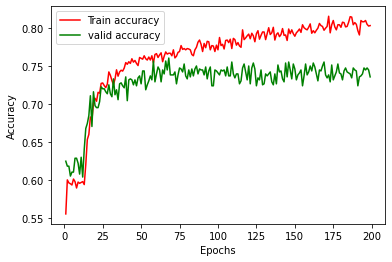

In [127]:
plt.plot([i for i in range(1,epochs)],[i for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[i  for i in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


### Saving Model

In [188]:
torch.save(net,"model-GCN")

In [189]:
model1 = torch.load("model-GCN")

In [187]:
model1.eval()
model1.to("cpu")
model1([*testloader][4])

tensor([[0.4506]], grad_fn=<SigmoidBackward0>)